### Resnet 코드



In [1]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split

# Helper libraries
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
BATCH_SIZE = 64
EPOCH = 20
current_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()


In [3]:
def set_seed(seed=42):
    # 1. 기본 파이썬 및 넘파이 시드 고정
    random.seed(seed)
    np.random.seed(seed)

    # 2. 파이토치 CPU 및 GPU 시드 고정
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # 멀티 GPU 사용 시 필수

    # 3. CuDNN 알고리즘 고정 (재현성을 위한 핵심)
    # 연산 속도가 약간 느려질 수 있지만, 결과는 일정해집니다.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
g = torch.Generator()
g.manual_seed(42)

## 데이터셋 구축 및 계층적 분할 검증

In [5]:
def get_stratified_cifar10(total_samples=10000, train_ratio=0.8, batch_size=32, num_workers=0):
    """
    CIFAR-10 데이터셋을 지정된 개수만큼 클래스 비율에 맞춰 추출하고 분할합니다.
    
    Args:
        total_samples (int): 전체 60,000개 중 사용할 데이터 총합
        train_ratio (float): total_samples 중 학습 데이터가 차지할 비율 (0.0 ~ 1.0)
        batch_size (int): 배치 사이즈
        num_workers (int): 데이터 로딩에 사용할 프로세스 수
    """
    
    # 1. Transform 정의
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # 2. 전체 데이터셋 로드 (학습용+테스트용 합치기)
    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    full_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
    full_dataset = ConcatDataset([full_train, full_test])
    
    # 3. 모든 데이터의 라벨(targets) 추출
    all_labels = np.array(full_train.targets + full_test.targets)
    indices = np.arange(len(all_labels))

    # 4. 단계 1: 전체에서 원하는 total_samples만큼 클래스 비율에 맞춰 랜덤 추출
    selected_indices, _ = train_test_split(
        indices, 
        train_size=total_samples, 
        stratify=all_labels, 
        random_state=42, # 결과 재현을 위한 시드
        shuffle=True
    )
    
    # 선택된 인덱스들의 라벨 정보 추출
    selected_labels = all_labels[selected_indices]

    # 5. 단계 2: 선택된 데이터 내에서 학습용/테스트용으로 분할
    train_idx, test_idx = train_test_split(
        selected_indices, 
        train_size=train_ratio, 
        stratify=selected_labels, 
        random_state=42,
        shuffle=True
    )

    # 6. Subset을 이용한 데이터셋 생성
    train_set = Subset(full_dataset, train_idx)
    test_set = Subset(full_dataset, test_idx)

    classes = full_train.classes 
    train_set.classes = classes
    test_set.classes = classes

    # 7. DataLoader 생성
    train_loader = DataLoader(
        train_set, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers
    )
    
    test_loader = DataLoader(
        test_set, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers
    )

    print(f"--- 데이터셋 구성 완료 ---")
    print(f"전체 사용 데이터: {len(selected_indices)}개")
    print(f"학습 데이터: {len(train_set)}개 (비율: {train_ratio})")
    print(f"테스트 데이터: {len(test_set)}개 (나머지)")
    
    return train_set, test_set, train_loader, test_loader, all_labels

In [6]:
trainset, testset, trainloader, testloader, labels = get_stratified_cifar10(total_samples=20000, train_ratio=0.8, batch_size = BATCH_SIZE)

--- 데이터셋 구성 완료 ---
전체 사용 데이터: 20000개
학습 데이터: 16000개 (비율: 0.8)
테스트 데이터: 4000개 (나머지)


In [7]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, _ = trainset[0]

print(f"Image shape: {image.shape}")

Image shape: torch.Size([3, 224, 224])


In [8]:
def print_subset_dist(subset, labels, title="Dataset"):
    # Subset이 가진 인덱스들을 이용해 해당 라벨들만 추출
    subset_labels = labels[subset.indices]
    counts = Counter(subset_labels)
    class_names = subset.classes
    
    
    print(f"\n=== {title} Distribution ===")
    # 클래스 이름 순서대로 출력
    print(class_names)
    for i, name in enumerate(subset.classes):
        print(f"{name:12}: {counts[i]} samples")

# 3. 실행
print_subset_dist(trainset, labels, "Train Set")
print_subset_dist(testset, labels, "Test Set")


=== Train Set Distribution ===
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
airplane    : 1600 samples
automobile  : 1600 samples
bird        : 1600 samples
cat         : 1600 samples
deer        : 1600 samples
dog         : 1600 samples
frog        : 1600 samples
horse       : 1600 samples
ship        : 1600 samples
truck       : 1600 samples

=== Test Set Distribution ===
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
airplane    : 400 samples
automobile  : 400 samples
bird        : 400 samples
cat         : 400 samples
deer        : 400 samples
dog         : 400 samples
frog        : 400 samples
horse       : 400 samples
ship        : 400 samples
truck       : 400 samples


## 데이터 샘플 시각화 및 검토

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [10]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.38770443..1.732854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45620346..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.584706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2763936..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7142857].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5178571.

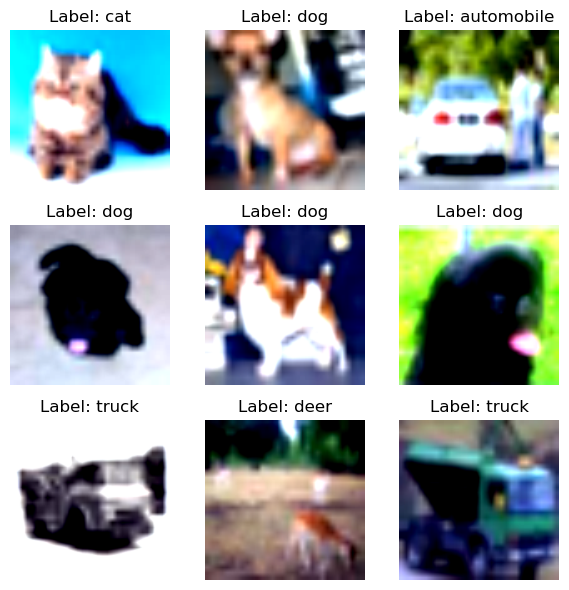

In [11]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.32776785..0.82653606].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..0.9908383].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44782913..1.453987].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47408962..1.7677125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.48189062..1.6195644].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1822074..

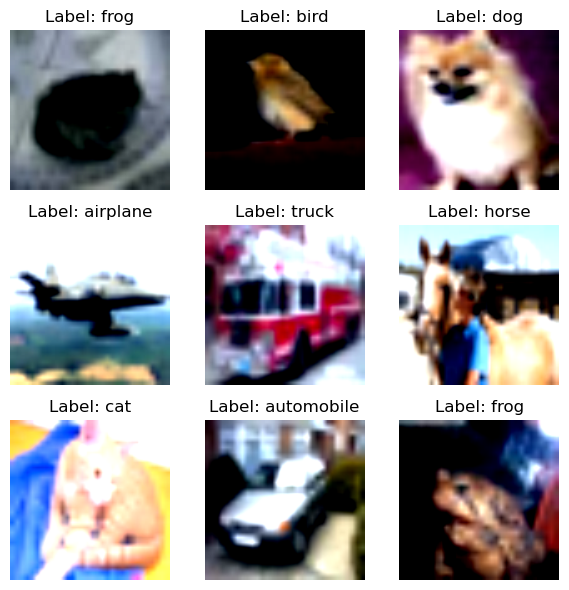

In [12]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

## ResNet 모델 아키텍처 설계 및 정의

In [13]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, is_skip = True):
        super().__init__()
        self.is_skip = is_skip
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.is_skip:
            out += self.shortcut(x)
        out = self.relu(out)
        return out

In [14]:
class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, is_skip = True):
        super().__init__()
        self.is_skip = is_skip
        self.conv1 = nn.Conv2d(
            inplanes, planes,
            kernel_size=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, planes,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(
            planes, self.expansion*planes,
            kernel_size=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)
        self.relu = nn.ReLU(inplace=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or inplanes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    inplanes, self.expansion*planes,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.is_skip:
            out += self.shortcut(x)

        out = self.relu(out)
        return out

In [15]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000,is_skip = True):
        super().__init__()

        self.inplanes = 64
        self.stem = nn.Sequential(
            nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.inplanes),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.stage1 = self._make_layer(block, 64, layers[0], stride=1, is_skip = is_skip)
        self.stage2 = self._make_layer(block, 128, layers[1], stride=2, is_skip = is_skip)
        self.stage3 = self._make_layer(block, 256, layers[2], stride=2, is_skip = is_skip)
        self.stage4 = self._make_layer(block, 512, layers[3], stride=2, is_skip = is_skip)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, is_skip):
      layers = []
      layers.append(block(self.inplanes, planes, stride, is_skip=is_skip))

      self.inplanes = planes * block.expansion
      for _ in range(num_blocks - 1):
          layers.append(block(self.inplanes, planes, 1, is_skip=is_skip))

      return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

## 학습 및 검증 프로세스의 모듈화 설계

In [16]:
def evaluate(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [17]:
def train_model(model, trainloader, testloader, criterion, optimizer, device, epochs, save_path):
    train_losses = []
    val_accuracies = []

    start_time = time.time() # 전체 학습 시작 시간 측정
    print(f"Training started on {device}...")

    for epoch in range(epochs):
        # 학습 모드
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 50 == 49:
                print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}")

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)

        val_acc = evaluate(model, testloader, device)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch + 1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    end_time = time.time()
    print("Finished Training")
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    # 모델의 가중치(weights)만 저장하는 방식 (권장)
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

    return train_losses, val_accuracies

## 모델별 동적 저장 경로 설정

In [18]:
save_dir = "./models/"
os.makedirs(save_dir, exist_ok=True)

In [19]:
def modelSavePath(save_dir, model_name, is_skip = True):
    if is_skip == True:
        model_mode = "residual"
    else:
        model_mode = "plain"  
    
    file_name = f"{model_name}_{model_mode}.pth"
    save_path = os.path.join(save_dir, file_name)

    return save_path

---

In [20]:
# ResNet: residual block
is_skip =  True

## ResNet34: residual 학습

In [21]:
set_seed(42)

In [22]:
model_name = "resnet34"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [23]:
resnet34 = ResNet(BasicBlock, [3, 4, 6, 3], 10, is_skip = is_skip ).to(device)

In [24]:
# resnet34 아키텍처 시각화
resnet34

ResNet(
  (stem): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (stage1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [25]:
optimizer = optim.SGD(resnet34.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
resnet34_train_losses, resnet34_val_accs = train_model(
    resnet34, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

Training started on cuda...


## ResNet50: residual 학습

In [ ]:
set_seed(42)

In [ ]:
model_name = "resnet50"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [ ]:
resnet50 = ResNet(BottleneckBlock, [3, 4, 6, 3], 10,is_skip = is_skip).to(device)

In [ ]:
# resnet50 아키텍처 시각화
resnet50

In [ ]:
optimizer = optim.SGD(resnet50.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
resnet50_train_losses, resnet50_val_accs = train_model(
    resnet50, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

In [ ]:
# Residual 레이어 여부
print(resnet50.stage1[0].shortcut[0].weight.grad)

### ResNet | Residual 실험 결과 시각화 및 성능 비교 분석

In [ ]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Validation Accuracy")
plt.plot(resnet50_val_accs, 'b', label="ResNet50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### 그래프 분석
ResNet34, ResNet50의 Traininmg Loss 그래프를 비교해보면 이론상 ResNet50의 Traininmg Loss가 더 낮은 모습을 보여야 한다.
ResNet34, ResNet50의 Validation Accuracy 그래프를 비교해보면 이론상 ResNet50의 Validation Accuracy가 더 높은 모습을 보여야 한다.
>  하지만 실제 그래프를 보면 그렇지 않은 것을 볼 수 있다  

이와 같은 결과가 나온 이유를 추측해보면
1. 충분하지 않은 학습량(20 epoch)으로 충분한 학습을 이루지 못함
    - 그 증거로 train acc는 100%에 근접했지만 val acc는 그러지 못한 것을 확인할 수 있음
2. 데이터셋의 결정적인 결함
  - CIFAR10 데이터를 활용하고, 학습 시간 단축을 위해 전체 데이터에서 20000개를 학습 데이터와 검증 데이터로 분리했다
  - CIFAR10 데이터를 32x32x3의 shape을 가지고 있다. 그렇기 때문에 CIFAR10 데이터를 그대로 ResNet에 입력으로 주면 합성곱 연산 과정에서 이미지가 소실되는 문제가 발생할 수 있다. 따라서 32x32를 224x224로 resize를 한 후 모델의 입력으로 주고 있다.
  - 또한 CIFAR10의 클래스는 10개이며 이를 전체데이터 20000개로 축소하고 학습용과 검증용으로 나누었다(0.8:0.2)  
    그렇기 때문에 각 클래스의 이미지는 1600개이다 모델이 학습하기에는 적은 수이다.

이러한 요인으로 ResNet34, ResNet50의 모델 성능이 이론적으로 좋게 나오지 못한 것으로 추측됨

---

In [ ]:
# ResNet: plain block
is_skip =  False

## ResNet34: Plain 학습

In [ ]:
set_seed(42)

In [ ]:
model_name = "resnet34"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [ ]:
resnet34_Plain = ResNet(BasicBlock, [3, 4, 6, 3], 10, is_skip = is_skip ).to(device)

In [ ]:
optimizer = optim.SGD(resnet34_Plain.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
resnet34_Plain_train_losses, resnet34_Plain_val_accs = train_model(
    resnet34_Plain, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

## ResNet50: Prain 학습

In [ ]:
set_seed(42)

In [ ]:
model_name = "resnet50"  
save_path = modelSavePath(save_dir, model_name, is_skip)

In [ ]:
resnet50_Plain = ResNet(BottleneckBlock, [3, 4, 6, 3], 10,is_skip = is_skip).to(device)

In [ ]:
optimizer = optim.SGD(resnet50_Plain.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

In [ ]:
resnet50_Plain_train_losses, resnet50_Plain_val_accs = train_model(
    resnet50_Plain, trainloader, testloader, criterion, optimizer, device, epochs=EPOCH, save_path = save_path 
)

In [ ]:
# Residual 레이어 여부
print(resnet50_Plain.stage1[0].shortcut[0].weight.grad)

### ResNet | Plain 실험 결과 시각화 및 성능 비교 분석

In [ ]:
plt.plot(resnet34_Plain_train_losses, 'r', label="ResNet34 Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b', label="ResNet50 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(resnet34_Plain_val_accs, 'r', label="ResNet50 Validation Accuracy")
plt.plot(resnet50_Plain_val_accs, 'b', label="ResNet50 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### ResNet | Residual&Plain 실험 결과 시각화 및 성능 비교 분석

In [ ]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Residual Training Loss")
plt.plot(resnet50_train_losses, 'b', label="ResNet50 Residual Training Loss")
plt.plot(resnet34_Plain_train_losses, 'r--', label="ResNet34 Plain Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b--', label="ResNet50 Plain Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Residual Val Acc")
plt.plot(resnet50_val_accs, 'b', label="ResNet50 Residual Val Acc")
plt.plot(resnet34_Plain_val_accs, 'r--', label="ResNet34 Plain Val Acc")
plt.plot(resnet50_Plain_val_accs, 'b--', label="ResNet50 Plain Val Acc")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(resnet34_train_losses, 'r', label="ResNet34 Residual Training Loss")
plt.plot(resnet34_Plain_train_losses, 'b', label="ResNet34 Plain Training Loss")

plt.title('ResNet34 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(resnet50_train_losses, 'r', label="ResNet50 Residual Training Loss")
plt.plot(resnet50_Plain_train_losses, 'b', label="ResNet50 Plain Training Loss")

plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(resnet34_val_accs, 'r', label="ResNet34 Residual Val Acc")
plt.plot(resnet34_Plain_val_accs, 'b', label="ResNet34 Plain Val Acc")

plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(resnet50_val_accs, 'r', label="ResNet50 Residual Val Acc")
plt.plot(resnet50_Plain_val_accs, 'b', label="ResNet50 Plain Val Acc")

plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

## Confusion matrice

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns

def run_final_evaluation(model, testloader, device, classes):
    # 1. 평가 모드 전환
    model.eval()
    
    all_preds = []
    all_labels = []
    all_probs = []

    print("데이터 검증 중...")
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 모델 예측 (에러 방지를 위해 인스턴스 호출)
            outputs = model(inputs)
            
            # 확률값(ROC-AUC용) 및 예측값(Confusion Matrix용) 추출
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # --- [결과 출력 1] Classification Report (Precision, Recall, F1) ---
    print("\n" + "="*50)
    print("1. 분류 상세 리포트")
    print("="*50)
    print(classification_report(all_labels, all_preds, target_names=classes))

    # --- [결과 출력 2] ROC-AUC Score ---
    auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    print(f"2. ROC-AUC Score (Overall): {auc:.4f}")

    # --- [결과 출력 3] Confusion Matrix 시각화 ---
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [ ]:
resnet34.load_state_dict(torch.load('./models/resnet34_residual.pth', map_location=device))
resnet34.to(device)

run_final_evaluation(resnet34, testloader, device,testset.classes)

In [ ]:
resnet50.load_state_dict(torch.load('./models/resnet50_residual.pth', map_location=device))
resnet50.to(device)

run_final_evaluation(resnet50, testloader, device, testset.classes)

In [ ]:
resnet34_Plain.load_state_dict(torch.load('./models/resnet34_plain.pth', map_location=device))
resnet34_Plain.to(device)

run_final_evaluation(resnet34_Plain, testloader, device, testset.classes)

In [ ]:
resnet50_Plain.load_state_dict(torch.load('./models/resnet50_plain.pth', map_location=device))
resnet50_Plain.to(device)

run_final_evaluation(resnet50_Plain, testloader, device, testset.classes)

# ResNet - TensorFlow dataset

In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

# Dataset download
import os
import zipfile
import urllib.request
from PIL import Image
from collections import Counter

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --- [설정 및 상수] ---
DATA_URL = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
ZIP_PATH = "cats_and_dogs.zip"
EXTRACT_PATH = "cats_vs_dogs_data"
IMG_SIZE = (224, 224)
# ResNet 표준 정규화 수치
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

In [ ]:
# --- [함수 1: 데이터 다운로드 및 압축 해제] ---
def download_and_extract(url, zip_p, extract_p):
    if not os.path.exists(zip_p):
        print("데이터셋 다운로드 중...")
        urllib.request.urlretrieve(url, zip_p)
    if not os.path.exists(extract_p):
        print("압축 해제 중...")
        with zipfile.ZipFile(zip_p, 'r') as zip_ref:
            zip_ref.extractall(extract_p)
    print("데이터 준비 완료.")

In [ ]:
# --- [함수 2: 손상된 이미지 제거] ---
def clean_dataset(root_path):
    print("손상된 이미지 확인 및 제거 중...")
    count = 0
    for subdir, dirs, files in os.walk(root_path):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                file_path = os.path.join(subdir, file)
                try:
                    img = Image.open(file_path)
                    img.verify()
                except (IOError, SyntaxError):
                    os.remove(file_path)
                    count += 1
    print(f"제거된 손상 이미지: {count}개")

In [ ]:
# --- [함수 3: 1:1 균형 잡힌 데이터 분할] ---
def get_balanced_subsets(full_dataset, n_train_per_class, n_test_per_class):
    cat_indices = [i for i, label in enumerate(full_dataset.targets) if label == 0]
    dog_indices = [i for i, label in enumerate(full_dataset.targets) if label == 1]

    np.random.shuffle(cat_indices)
    np.random.shuffle(dog_indices)

    train_idx = cat_indices[:n_train_per_class] + dog_indices[:n_train_per_class]
    test_idx = cat_indices[n_train_per_class : n_train_per_class + n_test_per_class] + \
               dog_indices[n_train_per_class : n_train_per_class + n_test_per_class]

    return Subset(full_dataset, train_idx), Subset(full_dataset, test_idx)

In [ ]:
# --- [함수 4: 분포 확인 및 시각화] ---
def check_dist(dataset, title, classes):
    labels = [dataset.dataset.targets[i] for i in dataset.indices]
    counts = Counter(labels)
    print(f"\n[{title}]")
    for i, name in enumerate(classes):
        print(f" - {name}: {counts[i]}개 ({(counts[i]/len(labels))*100:.1f}%)")

In [ ]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    img = np.array(NORM_STD) * img + np.array(NORM_MEAN) # 정규화 해제
    img = np.clip(img, 0, 1)
    return img

In [ ]:
def show_samples(loader, classes):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(3, 3, figsize=(7, 7))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imshow(images[i]))
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# 1. 데이터 다운로드 및 환경 정리
download_and_extract(DATA_URL, ZIP_PATH, EXTRACT_PATH)
clean_dataset(os.path.join(EXTRACT_PATH, "PetImages"))

In [ ]:
# 2. 전처리 정의
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

In [ ]:
# 3. 원본 데이터셋 로드
full_dataset = datasets.ImageFolder(root=os.path.join(EXTRACT_PATH, "PetImages"), transform=transform)

In [ ]:
# 4. 1:1 균형 분할 (학습용 각 800개, 테스트용 각 200개 설정)
train_set, test_set = get_balanced_subsets(full_dataset, n_train_per_class=800, n_test_per_class=200)

In [ ]:
# 5. 최종 DataLoader 생성
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# 6. 결과 검증
check_dist(train_set, "학습 데이터 분포", full_dataset.classes)
check_dist(test_set, "테스트 데이터 분포", full_dataset.classes)
show_samples(train_loader, full_dataset.classes)

# VGG16 vs VGG18

In [ ]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

In [ ]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

In [ ]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

In [ ]:
# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

In [ ]:
num_classes = len(trainset.classes)
print(num_classes)

In [ ]:
class_names = trainset.classes
print(class_names)

In [ ]:
class_names = trainset.classes
print(class_names)

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))


In [ ]:
def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

In [ ]:
# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

In [ ]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3,
                    channel=64,
                    block_num=1):
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    layers = []
    in_channels = x.size(1)
    for cnn_num in range(num_cnn):
        layers.append(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=channel,
                kernel_size=3,
                stride=1,
                padding=1,
            )
        )
        layers.append(nn.ReLU(inplace=True))
        in_channels = channel

    # Max Pooling 레이어
    layers.append(
        nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
    )

    # Sequential으로 레이어 묶기
    block = nn.Sequential(*layers)
    return block

In [ ]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        # VGG 블록 생성
        self.vgg_block = build_vgg_block(torch.zeros(1, 3, 32, 32))
    def forward(self, x):
        return self.vgg_block(x)

In [ ]:
# 블록 1개짜리 model 생성
model = VGGNet()
print(model)

dummy_input = torch.zeros(1, 3, 32, 32)
output = model(dummy_input)
print(output.shape)

In [ ]:
# VGG 모델 자체를 생성하는 클래스입니다.
class VGG(nn.Module):
    def __init__(self, num_cnn_list=[2, 2, 3, 3, 3], channel_list=[64, 128, 256, 512, 512], num_classes=10):
        super(VGG, self).__init__()
        assert len(num_cnn_list) == len(channel_list), "num_cnn_list와 channel_list의 길이가 일치해야 합니다."

        layers = []
        in_channels = 3

        for num_cnn, out_channels in zip(num_cnn_list, channel_list):
            layers.append(self._make_vgg_block(in_channels, out_channels, num_cnn))
            in_channels = out_channels  # 다음 블록의 입력 채널을 설정

        self.feature_extractor = nn.Sequential(*layers)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Linear(4096, num_classes)
        )

    def _make_vgg_block(self, in_channels, out_channels, num_cnn):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), nn.ReLU(True)]
        for _ in range(num_cnn - 1):
            layers.append(nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU(True))
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))  # Max Pooling 추가
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [ ]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.

vgg_16 = VGG()
print(vgg_16)

In [ ]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = VGG(
    num_cnn_list=[2, 2, 4, 4, 4],
    channel_list=[64, 128, 256, 512, 512]
)
print(vgg_19)

In [ ]:
# Q. VGG-16보다 작은 네트워크인 VGG-13을 만들어 보세요.
def build_vgg13(num_classes=10):
    return VGG(
        num_cnn_list=[2, 2, 2, 2, 2],
        channel_list=[64, 128, 256, 512, 512],
        num_classes=num_classes
    )

In [ ]:
vgg_13 = build_vgg13()
print(vgg_13)

In [ ]:
BATCH_SIZE = 256
EPOCH = 15

In [ ]:
# CIFAR-10 데이터셋에 대해 Normalize와 Tensor 변환을 적용하는 코드
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # VGG-16 표준 정규화
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
import time

current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_16 = torchvision.models.vgg16(pretrained=True)
vgg_16.to(device)

for param in vgg_16.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_16.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_16_train_losses = []
vgg_16_val_accuracy = []


for epoch in range(EPOCH):
    vgg_16.train()
    correct = 0
    running_loss = 0.0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}")

    train_loss = running_loss / len(trainloader)
    train_acc = 100 * correct / total
    vgg_16_train_losses.append(train_loss)

    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_16.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_16(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_16_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

In [ ]:
current_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg_19 = torchvision.models.vgg19(pretrained=True)
vgg_19.to(device)

for param in vgg_19.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg_19.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

vgg_19_train_losses = []
vgg_19_val_accuracy = []

for epoch in range(EPOCH):
    vgg_19.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(trainloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = vgg_19(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}")

    train_loss = running_loss / len(trainloader)
    vgg_19_train_losses.append(train_loss)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch + 1}: Train Accuracy: {train_acc:.2f}%")

    vgg_19.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg_19(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    vgg_19_val_accuracy.append(val_acc)

    print(f"Epoch {epoch + 1}: Validation Accuracy: {val_acc:.2f}%")

print("Finished Training")
print(time.time() - current_time)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(vgg_16_train_losses, 'r', label="VGG-16 Training Loss")
plt.plot(vgg_19_train_losses, 'b', label="VGG-19 Training Loss")

plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [ ]:
plt.plot(vgg_16_val_accuracy, 'r', label="VGG-16 Validation Accuracy")
plt.plot(vgg_19_val_accuracy, 'b', label="VGG-19 Validation Accuracy")

plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()